# RNN Based molucule generation

Laurent Cetinsoy

In this hands-on we want to generate molecule formulas for denovo-drug discovery.

For that we need to use Generative models. Generative models are models which goes beyond classification or simple regression : they are able to generate data that look like previously seens dataset.

There exists a lot of models :

- Bayesian models like graphical models
- Recurrent models (for sequence generation like texte)
- Variational auto encoders
- Generative adversarial models
- Flow and diffusion models


In the hands-on we will start by  trainning a character based RNN to generate smile molecules


We want to feed smile representations of molecules to an RNN.
The basic idea is we will train it to predict the next smile token of a molecule given the previous one.

For instance for the following molecule "CC(=O)NC1=CC=C(O)C=C1" will may give to the model

X = "CC(=O)N"
y = C

and ask the RNN to learn to predict y given X

Like a standard language model !


## RNN Language model


A language model is a model which predict the next token of a sequence given the previous ones :

$ P(X_t | X_{t-1}, X_{t-2}, ..., X_{t-p})  $


This model can be learned with a Recurrent neural network

$ y = P(X_t | X_{t-1}, X_{t-2}, ..., X_{t-p}) = RNN_{\theta} (X_{t-1}, X_{t-2}, ..., X_{t-p})  $


In order to train such model you need a corpus of data.



There are two main ways to do that : Word level model or character level model

For character level models, an interesting resource is : http://karpathy.github.io/2015/05/21/rnn-effectiveness/



Explain briefly what is the difference between word based language model and character based language model

Modèle de langage basé sur les mots : Prédit le mot suivant dans une séquence de mots en utilisant un vocabulaire pré-défini de mots.

Modèle de langage basé sur les caractères : Prédit le caractère suivant dans une séquence de caractères, n'utilise pas de vocabulaire pré-défini et peut générer de nouveaux mots.

## Loading the data

Dowload the following dataset : https://github.com/joeymach/Leveraging-VAE-to-generate-molecules

Import pandas and load the first 1000 lines

In [2]:
import pandas as pd

data = pd.read_csv("/kaggle/input/smiles/250k_smiles.csv")
data = data[:1000]

Display the first rows of the dataframe

In [3]:
data.head()

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


## Processing the data

We need to do the following things :

- convert smile tokens to numbers
- build  smile token sequences and corresponding labels pairs

Compute the biggest smile molecule size

In [4]:
longest_smiles = data['smiles'].apply(len).idxmax()
longest_smiles_string = data.loc[longest_smiles, 'smiles']

print("SMILES with the Longest String Length:")
print(longest_smiles_string)


SMILES with the Longest String Length:
C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C(=O)[O-])NC1=O




Code a function **unic_characters(string)** which return the unic characters in a string


In [5]:
def unic_characters(input_string):
    unique_chars = set()

    for char in input_string:
        unique_chars.add(char)

    unique_string = ''.join(unique_chars)
    return unique_string

In [6]:
unic_characters(longest_smiles_string)

'\\]()N-1[2H\n@/OC='

Concatenate all smile string of the pandas dataframe and use **unic_characters** to get the unic_characters

In [7]:
all_smiles = ''.join(data['smiles'])
unic_char = unic_characters(all_smiles)
unic_char

'\\B-lH/C=67Is3Fo5@](Nc12n\n[rOS)+#4'

Code a function **map_char_to_int(unic_chars)** which returns a dictionnary where each char is assigned an int value.
Add a character to specify the end of the molecule (like "\n")


In [8]:
def map_char_to_int(unique_chars):
    char_to_int = {}

    for i, char in enumerate(unique_chars):
        char_to_int[char] = i

    end_of_molecule_char = '\n'
    char_to_int[end_of_molecule_char] = len(unique_chars)

    return char_to_int

Code a function map_int_to_char(unic_chars) which returns the reverse mapping.

If you want you can merge both functions in a class

In [9]:
def map_int_to_char(unique_chars):
    int_to_char = {}

    for i, char in enumerate(unique_chars):
        int_to_char[i] = char

    end_of_molecule_char = '\n'
    int_to_char[len(unique_chars)] = end_of_molecule_char

    return int_to_char

For each smile molecule add the ending token to it

In [10]:
def add_ending_token(smiles, ending_token):
    if '\n' not in smiles:
        return smiles + ending_token
    else:
        return smiles

ending_token = '\n'  # Customize the ending token as needed
data['smiles_with_ending_token'] = data['smiles'].apply(add_ending_token, args=(ending_token,))

## Building the dataset

Now we will create the dataset so that it has the good share for our Keras LSTM model

Remember Keras recurrent models expect a 3D array with shapes (n_examples, seq_len, n_features)



What will be n_features in our case ?

In the context of building a dataset for a Keras LSTM model, n_features would typically represent the number of unique characters (including the ending token) in your SMILES dataset.

Code a function **build_X_and_y(string, i_char, seq_lenght)** which takes a string, a **seq_length** number and a position.


It should create X by by getting all character between i and i + seq_length
and create y by getting the character following the X sequence
it returns X and y

Test your function on the following string "" with seq_length = 4 and i = [1, 2, 3]

In [11]:
def build_X_and_y(input_string, i_char, seq_length):
    X = input_string[i_char:i_char + seq_length]
    y = input_string[i_char + seq_length]

    return X, y

In [12]:
input_string = "bonjour_comment_vous_allez"
seq_length = 4
i_char = [1, 2, 3]

for i in i_char:
  X, y = build_X_and_y(input_string, i, seq_length)
  print("X:", X)
  print("y:", y)

X: onjo
y: u
X: njou
y: r
X: jour
y: _


By using build_X_and_y and map_char_to_int build a list nameed X_train and a list named y_train

In [13]:
seq_length_test = 10
all_smiles = ''.join(data['smiles_with_ending_token'])

char_to_int_mapping = map_char_to_int(unic_char)
int_to_char_mapping = map_int_to_char(unic_char)
X_train = []
y_train = []

max_length = len(all_smiles) - seq_length_test

for i in range(max_length):
    X_seq, y_char = build_X_and_y(all_smiles, i, seq_length_test)

    X_int_seq = [char_to_int_mapping[char] for char in X_seq]
    X_train.append(X_int_seq)

    y_int = char_to_int_mapping[y_char]
    y_train.append(y_int)

Create numpy arrays from the lists

In [14]:
import numpy as np

X_train_array = np.array(X_train)
y_train_array = np.array(y_train)

Reshape the X numpy array (n_examples, seq_lenght, 1)

In [15]:
X_train_array = X_train_array.reshape(X_train_array.shape[0], seq_length_test, 1)

Normalize X by dividing each values by the total number of unic characters

In [16]:
total_unique_characters = len(unic_char)

X_train_array = X_train_array / total_unique_characters

Import Keras and build (at least) a two layered LSTM network with 128 neurone in each.

You can also add Dropoutlayers

Do you think you should use the return_sequences = True ? If yes, when ?


Add a Dense layer on top with with the appropriate activation function and number of neurones


  We should use return_sequences=True for the first LSTM layer if we plan to stack multiple LSTM layers on top of each other and want each layer to return sequences as input to the next layer. This is typically used in sequence-to-sequence models.

  If we have a sequence-to-vector model, where the last LSTM layer produces the final output, we can set return_sequences=False for the last LSTM layer.

In [17]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

model = Sequential()

model.add(LSTM(128, input_shape=(seq_length_test, 1), return_sequences=True))

model.add(Dropout(0.2))

model.add(LSTM(128))

model.add(Dropout(0.2))

model.add(Dense(len(unic_char), activation='softmax'))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Compile the model with the appropriate loss function and the adam optimizer

In [18]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 33)                4257      
                                                                 
Total params: 202,401
Trainable params: 202,401
Non-trainable params: 0
_________________________________________________________________


Train the model on 20 epochs and 10 examples (yeah you read correctly) and check that the model overfits !

In [19]:
epochs = 20

X_train_10 = X_train_array[:10]
y_train_10 = y_train_array[:10]

history = model.fit(
    X_train_10,
    y_train_10,
    epochs=epochs
)

Epoch 1/20
1/1 [==============================] - 11s 11s/step - loss: 3.4971 - accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 13ms/step - loss: 3.4436 - accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 0s 13ms/step - loss: 3.3922 - accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 0s 12ms/step - loss: 3.3159 - accuracy: 0.5000
Epoch 5/20
1/1 [==============================] - 0s 11ms/step - loss: 3.2593 - accuracy: 0.5000
Epoch 6/20
1/1 [==============================] - 0s 13ms/step - loss: 3.1503 - accuracy: 0.5000
Epoch 7/20
1/1 [==============================] - 0s 12ms/step - loss: 3.0220 - accuracy: 0.5000
Epoch 8/20
1/1 [==============================] - 0s 11ms/step - loss: 2.8680 - accuracy: 0.5000
Epoch 9/20
1/1 [==============================] - 0s 11ms/step - loss: 2.5939 - accuracy: 0.5000
Epoch 10/20
1/1 [==============================] - 0s 11ms/step - loss: 2.3559 - accuracy: 0.5000
Epoch 11/20
1/1 [========

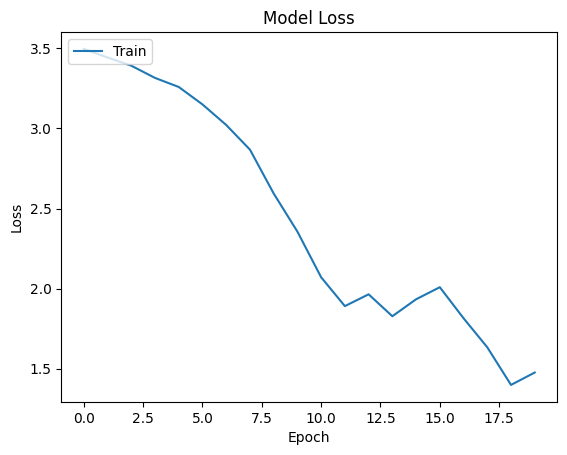

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper left')
plt.show()

If it does not overfit try to fix data prep and model architecture so it does

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 3.4933 - accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 13ms/step - loss: 3.4403 - accuracy: 0.5000
Epoch 3/50
1/1 [==============================] - 0s 13ms/step - loss: 3.4071 - accuracy: 0.5000
Epoch 4/50
1/1 [==============================] - 0s 13ms/step - loss: 3.3667 - accuracy: 0.5000
Epoch 5/50
1/1 [==============================] - 0s 12ms/step - loss: 3.3254 - accuracy: 0.4000
Epoch 6/50
1/1 [==============================] - 0s 11ms/step - loss: 3.2298 - accuracy: 0.5000
Epoch 7/50
1/1 [==============================] - 0s 12ms/step - loss: 3.1352 - accuracy: 0.5000
Epoch 8/50
1/1 [==============================] - 0s 12ms/step - loss: 3.0521 - accuracy: 0.5000
Epoch 9/50
1/1 [==============================] - 0s 11ms/step - loss: 2.9447 - accuracy: 0.5000
Epoch 10/50
1/1 [==============================] - 0s 14ms/step - loss: 2.7992 - accuracy: 0.5000
Epoch 11/50
1/1 [==========

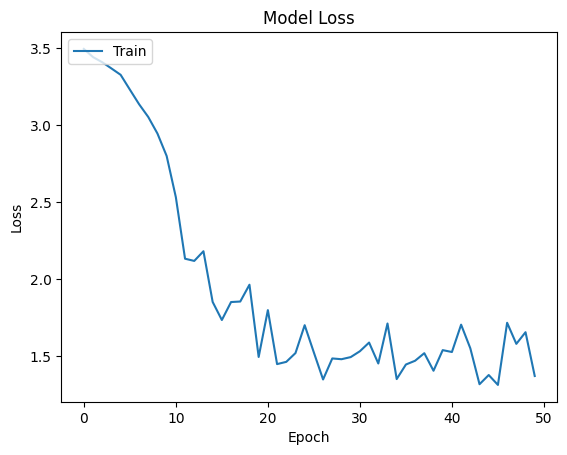

In [41]:
epochs = 50

X_train_10 = X_train_array[:10]
y_train_10 = y_train_array[:10]

model = Sequential()

model.add(LSTM(128, input_shape=(seq_length_test, 1), return_sequences=True))

model.add(Dropout(0.5))

model.add(LSTM(128))

model.add(Dropout(0.5))

model.add(Dense(len(unic_char), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(
    X_train_10,
    y_train_10,
    epochs=epochs
)

plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper left')
plt.show()

Create a function **make_prediction(seed_start)** which takes a starting string sequence and uses it to generate a molecule


In [22]:
def make_prediction(seed_start, model, int_to_char_mapping, max_length=100):
    generated_molecule = ''.join([int_to_char_mapping[char_int] for char_int in seed_start])

    for _ in range(max_length):
        input_seq = np.array(seed_start[-seq_length_test:]).reshape(1, seq_length_test, 1)

        predicted_char_int = np.argmax(model.predict(input_seq), axis=-1)[0]

        predicted_char = int_to_char_mapping[predicted_char_int]

        generated_molecule += predicted_char

        seed_start.append(predicted_char_int)

        if predicted_char == '\n':
            break

    return generated_molecule

generate a molecule of your overfitted model

In [23]:
overfitted_molecule = make_prediction(X_train[10], model, int_to_char_mapping)

1/1 [==============================] - 0s 23ms/step


In [24]:
overfitted_molecule

'ccc2occ(CCcccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc'

Make a model checkpoint so that the model is saved after each epoch
if you train on a plateform and it stops you do not lose your training

In [25]:
from keras.callbacks import ModelCheckpoint

# Define a checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='model_checkpoint.h5',  # Filepath to save the model
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    save_best_only=True,  # Save only the best models
    verbose=1  # Display progress
)

# Example of training with the checkpoint callback
history = model.fit(
    X_train_10,
    y_train_10,
    epochs=20,
    validation_split=0.2,
    callbacks=[checkpoint_callback]  # Add the checkpoint callback here
)

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 1.3732 - accuracy: 0.5000
Epoch 1: val_loss improved from inf to 1.60785, saving model to model_checkpoint.h5
1/1 [==============================] - 1s 891ms/step - loss: 1.3732 - accuracy: 0.5000 - val_loss: 1.6079 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 1.4308 - accuracy: 0.6250
Epoch 2: val_loss did not improve from 1.60785
1/1 [==============================] - 0s 40ms/step - loss: 1.4308 - accuracy: 0.6250 - val_loss: 1.6343 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 1.3415 - accuracy: 0.6250
Epoch 3: val_loss did not improve from 1.60785
1/1 [==============================] - 0s 41ms/step - loss: 1.3415 - accuracy: 0.6250 - val_loss: 1.6830 - val_accuracy: 0.0000e+00
Epoch 4/20
1/1 [==============================] - ETA: 0s - loss: 1.5067 - accuracy: 0.5000
Epoch 4: val_loss did not improve from 1.60785
1/1 [=====

Now go to your favorite plateform (colab or something else) and train the dataset on the whole data for 10 epochs and batch size 256

it should take a long time so either follow the class or go take a nap

In [46]:
X_train_array.shape

(45232, 10, 1)

Epoch 1/10
177/177 [==============================] - 13s 51ms/step - loss: nan - accuracy: 7.5168e-04
Epoch 2/10
177/177 [==============================] - 9s 51ms/step - loss: nan - accuracy: 5.7481e-04
Epoch 3/10
177/177 [==============================] - 9s 52ms/step - loss: nan - accuracy: 5.7481e-04
Epoch 4/10
177/177 [==============================] - 9s 52ms/step - loss: nan - accuracy: 5.7481e-04
Epoch 5/10
177/177 [==============================] - 9s 52ms/step - loss: nan - accuracy: 5.7481e-04
Epoch 6/10
177/177 [==============================] - 9s 51ms/step - loss: nan - accuracy: 5.7481e-04
Epoch 7/10
177/177 [==============================] - 9s 51ms/step - loss: nan - accuracy: 5.7481e-04
Epoch 8/10
177/177 [==============================] - 9s 51ms/step - loss: nan - accuracy: 5.7481e-04
Epoch 9/10
177/177 [==============================] - 9s 51ms/step - loss: nan - accuracy: 5.7481e-04
Epoch 10/10
177/177 [==============================] - 9s 51ms/step - loss: nan -

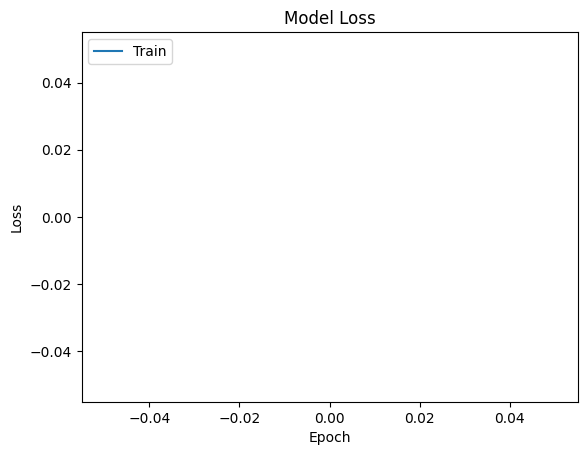

In [50]:
from tensorflow.keras.optimizers import Adam

# Define batch size and number of epochs
batch_size = 256
epochs = 10

model = Sequential()

model.add(LSTM(1024, input_shape=(seq_length_test, 1), return_sequences=True))

model.add(Dropout(0.5))

model.add(LSTM(1024))

model.add(Dropout(0.5))

model.add(Dense(len(unic_char), activation='softmax'))

optimizer = Adam(clipvalue=0.1)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(
    X_train_array,
    y_train_array,
    epochs=epochs,
    batch_size=batch_size
)

plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper left')
plt.show()

Generate between 100 and 1000 molecules.

create a list where molecules have between 10 and 50 atoms

With rdkit compute the Quantified Estimated Drug likelyness (QED) of each molecule in this subset

Bonus 1 : Using rdkit, compute the quantitative estimation of drug-likeness (QED) of your generated molecules.

Bonus 2 : try to adapt a transformer model training from hugging face to see if it is better